# Paraphrase Generation and Evaluation: From Dataset Creation to Model Fine-Tuning

This notebook walks through my comprehensive project on paraphrase generation and evaluation. I'll cover the entire pipeline from collecting data, generating paraphrases, training/utilizing specialized models, and evaluating their performance across different types of text and benchmarks

The goal was to fine-tune specialized models that can generate paraphrases that:

Preserve the original meaning
use diverse vocabulary and structure, and
Maintain the style appropriate to different text domains

To achieve this:

1. Created a diverse dataset from multiple domains (literary, technical, academic, article)
2. Generated high-quality paraphrases using LLMs
3. Fine-tuned using LoRA on DeepSeek-R1-Distill-Qwen-7B, utilized eugenesiow/bart-paraphrase and mrm8488/t5-small-finetuned-quora-for-paraphrasing (the last two were used as baseline)
4. Evaluated with multiple metrics (BertScore, inverseBleu ...)
5. Compared performance across different models and domains

In [ ]:
# If using colab and the codebase is there

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate where the dir is downloaded
# %cd /content/drive/MyDrive/Paraphrasing/Swisscome

/content/drive/MyDrive/Paraphrasing/Swisscome


In [3]:
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
from transformers import AutoTokenizer
from peft import LoraConfig
from trl import SFTTrainer

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
GPU memory: 42.47 GB


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import os
import random
from IPython.display import display, HTML

random.seed(42)
np.random.seed(42)

# 1. Dataset Collection and Preparation

## 1.1  Sentence Collection

Our first step was to collect a diverse set of sentences from various domains.

In [4]:
# Let's load our collected sentences
with open("data/evaluation/collected_sentences.json", "r") as f:
    collected_sentences = json.load(f)

domain_counts = {domain: len(sentences) for domain, sentences in collected_sentences.items()}
total_sentences = sum(domain_counts.values())

print(f"Total sentences collected: {total_sentences}")
for domain, count in domain_counts.items():
    print(f"  - {domain}: {count} sentences ({count/total_sentences*100:.1f}%)")

Total sentences collected: 212
  - literary: 125 sentences (59.0%)
  - technical: 2 sentences (0.9%)
  - academic: 57 sentences (26.9%)
  - article: 28 sentences (13.2%)


Our collection process used various sources:

- Literary: Sentences from classic novels like "The Great Gatsby" and "Pride and Prejudice"
- Technical: Documentation from GitHub repositories including React and TensorFlow
- Academic: Research papers including "Attention is All You Need" and "DeepSeek" publications
- Article: Contemporary articles on AI and technology trends

## 1.2 Data Preprocessing

Before using these sentences, we applied preprocessing:

- Removing extra whitespace
- Normalizing punctuation
- Ensuring proper sentence endings
- Filtering by minimum word count (30+)

This ensured our dataset contained substantial, well-formed sentences that would be challenging to paraphrase while preserving meaning.

# 2. Paraphrase Generation with LLMs

To create our gold-standard paraphrases, we used o4-mini to generate three distinct paraphrases for each sentence while preserving the original meaning:

In [ ]:
with open("data/evaluation/paraphrase_dataset.json", "r") as f:
    paraphrase_dataset = json.load(f)

complete_paraphrases = 0
total_items = 0

for domain, items in paraphrase_dataset.items():
    for item in items:
        total_items += 1
        if "paraphrases" in item and len(item["paraphrases"]) == 3:
            complete_paraphrases += 1

print(f"Total items: {total_items}")
print(f"Items with 3 paraphrases: {complete_paraphrases} ({complete_paraphrases/total_items*100:.1f}%)")

# Let's look at a random example
random_domain = random.choice(list(paraphrase_dataset.keys()))
random_item = random.choice(paraphrase_dataset[random_domain])

print(f"\nExample from {random_domain} domain:")
print(f"Original: {random_item['text']}")
if "paraphrases" in random_item:
    for i, para in enumerate(random_item["paraphrases"], 1):
        print(f"Paraphrase {i}: {para}")

Total items: 212
Items with 3 paraphrases: 212 (100.0%)

Example from literary domain:
Original: Mr. Collins no sooner saw the two girls than he began to congratulate them on their good fortune, which Charlotte explained by letting them know that the whole party was asked to dine at Rosings the next day.
Paraphrase 1: Hardly had Mr. Collins caught sight of the two girls before he was congratulating them on their good fortune, which Charlotte then clarified by informing them that the entire party had been invited to dine at Rosings the next day.
Paraphrase 2: Immediately upon seeing the two girls, Mr. Collins congratulated them on their luck, a gesture Charlotte elucidated by revealing that the whole party was invited to dinner at Rosings the following day.
Paraphrase 3: No sooner did Mr. Collins set eyes on the two girls than he began praising their good fortune, an explanation Charlotte provided by announcing that the entire party had been asked to dine at Rosings the next day.


The paraphrase generation prompt was carefully designed to:

- Preserve the original meaning
- Create diverse vocabulary and structure
- Maintain the appropriate tone and complexity
- Generate three distinct variations

## 2.1 Train/Test Splitting

We split our dataset into training (90%) and testing (10%) sets:

In [7]:
with open("data/evaluation/splits/paraphrase_train.json", "r") as f:
        train_data = json.load(f)
    
with open("data/evaluation/splits/paraphrase_test.json", "r") as f:
    test_data = json.load(f)

train_counts = {domain: len(sentences) for domain, sentences in train_data.items()}
test_counts = {domain: len(sentences) for domain, sentences in test_data.items()}

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())

print(f"Train set: {total_train} sentences ({total_train/(total_train+total_test)*100:.1f}%)")
print(f"Test set: {total_test} sentences ({total_test/(total_train+total_test)*100:.1f}%)")

# Domain distribution in train/test
train_dist = {domain: count/total_train*100 for domain, count in train_counts.items()}
test_dist = {domain: count/total_test*100 for domain, count in test_counts.items()}

print("\nDomain distribution:")
for domain in train_counts.keys():
    print(f"  - {domain}: {train_dist[domain]:.1f}% in train, {test_dist.get(domain, 0):.1f}% in test")

Train set: 190 sentences (89.6%)
Test set: 22 sentences (10.4%)

Domain distribution:
  - literary: 58.4% in train, 63.6% in test
  - article: 13.2% in train, 13.6% in test
  - academic: 27.4% in train, 22.7% in test
  - technical: 1.1% in train, 0.0% in test


# 3. Dataset Analysis

Let's analyze our dataset to understand the characteristics of sentences across domains:

Sentence statistics by domain (word count):


,mean_words,median_words,min_words,max_words,std_words
literary,47.216000,41.0,30.0,126.0,17.175603
technical,32.000000,32.0,32.0,32.0,0.000000
academic,41.315789,37.0,30.0,89.0,13.847741
article,41.285714,37.0,30.0,116.0,16.161809


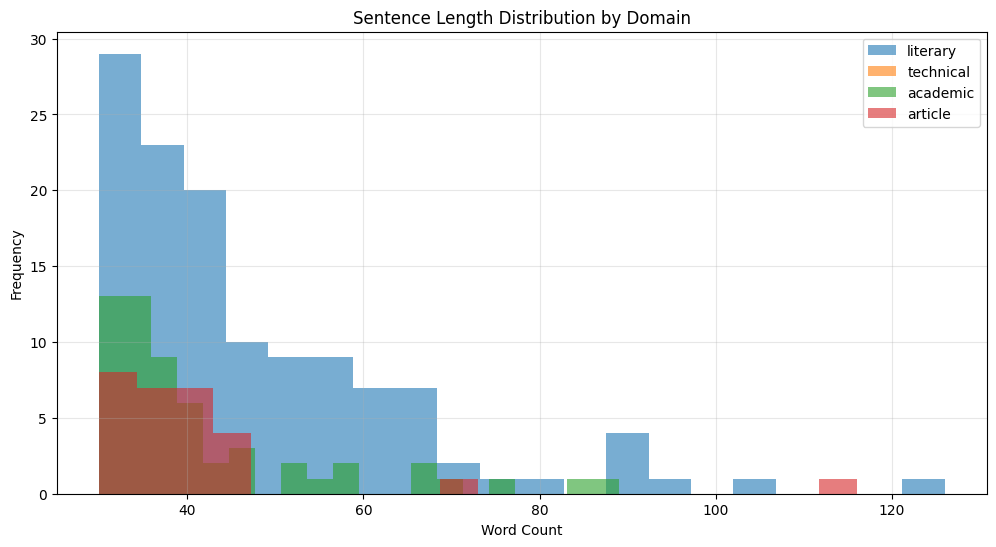

In [10]:
domain_stats = {}

for domain, items in collected_sentences.items():
    lengths = [len(word_tokenize(item["text"])) for item in items]
    domain_stats[domain] = {
        "mean_words": np.mean(lengths),
        "median_words": np.median(lengths),
        "min_words": np.min(lengths),
        "max_words": np.max(lengths),
        "std_words": np.std(lengths)
    }

stats_df = pd.DataFrame(domain_stats).T
print("Sentence statistics by domain (word count):")
display(stats_df)

plt.figure(figsize=(12, 6))
for domain in collected_sentences.keys():
    lengths = [len(word_tokenize(item["text"])) for item in collected_sentences[domain]]
    plt.hist(lengths, alpha=0.6, label=domain, bins=20)

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution by Domain')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Different domains have characteristic sentence structures and styles:

- Literary texts often have more varied sentence structures with descriptive language
- Technical documentation tends to be more concise and precise
- Academic text contains specialized terminology and complex constructions
- Articles balance readability with information density

# 4. Model Training and Evaluation

## 4.1 Fine-tuning DeepSeek with LoRA

We fine-tuned DeepSeek-R1-Distill-Qwen-7B with LoRA adapters for paraphrase generation

In [13]:
# Prompt format explanation
print("Training prompt format for DeepSeek-LoRA:")
print('''
"messages": [
    {
        "role": "user",
        "content": "Paraphrase the following text while preserving its meaning but changing the wording and structure: [original]"
    },
    {
        "role": "assistant",
        "content": "<think>\\nLet me analyze this text and find ways to rephrase it while keeping the same meaning.\\nI need to use different vocabulary and structure.\\n</think>\\n\\n[paraphrase]"
    }
]
''')

Training prompt format for DeepSeek-LoRA:

"messages": [
    {
        "role": "user",
        "content": "Paraphrase the following text while preserving its meaning but changing the wording and structure: [original]"
    },
    {
        "role": "assistant",
        "content": "<think>\nLet me analyze this text and find ways to rephrase it while keeping the same meaning.\nI need to use different vocabulary and structure.\n</think>\n\n[paraphrase]"
    }
]



In [11]:
!python train.py

2025-05-21 06:34:12.275953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747809252.297318   15762 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747809252.303835   15762 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-7B...
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100% 2/2 [00:04<00:00,  2.12s/it]
Adding LoRA adapters...
trainable params: 575,275,008 || all params: 8,190,891,520 || trainable%: 7.0234
Loading datasets...
Training dataset size: 2,570
Evaluation dataset size: 122
Initializing SFTTrainer...
Tokenizi

The training script used TRL's SFTTrainer with the following configuration (subset check train.py for more info):

- LoRA rank: 16
- LoRA alpha: 32
- Learning rate: 2e-4
- Epochs: 3
- Scheduler: Cosine with warmup
- Target modules: Attention (q_proj, k_proj, v_proj, o_proj) and MLP layers

## 4.2 Evaluation Metrics

Our evaluation system uses the following metrics to comprehensively assess paraphrase quality:

### 1. BERTScore
**Mathematical definition:** 
$$\text{BERTScore} = F_1(\text{P}, \text{R})$$
where:
- $\text{P} = \max_{j} \cos(\mathbf{x}_i, \mathbf{y}_j)$ (Precision)
- $\text{R} = \max_{i} \cos(\mathbf{x}_i, \mathbf{y}_j)$ (Recall)
- $\mathbf{x}_i, \mathbf{y}_j$ are contextualized embeddings of tokens

**Intuition:** BERTScore uses BERT embeddings to match words in the original and paraphrase texts. It aligns each word with its most similar counterpart in the other text, measuring cosine similarity between embeddings. This captures semantic similarity even when different words are used. Higher values (closer to 1) indicate better meaning preservation.

### 2. BLEU Diversity
**Mathematical definition:** 
$$\text{BLEU\_Diversity} = 1 - \text{BLEU}(original, paraphrase)$$

where BLEU is calculated as:
$$\text{BLEU} = BP \cdot \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)$$
- $p_n$ = n-gram precision
- $BP$ = brevity penalty
- $w_n$ = n-gram weights (we use $w_1=0.4, w_2=0.3, w_3=0.2, w_4=0.1$)

**Intuition:** BLEU measures n-gram overlap between texts, with a penalty for shorter outputs. By inverting it (1-BLEU), we measure lexical diversity. Higher BLEU_Diversity values indicate more diverse word choices and phrasing.

### 3. Edit Distance
**Mathematical definition:** 
$$\text{Edit\_Distance} = \frac{\text{Levenshtein}(original, paraphrase)}{\max(\text{len}(original), \text{len}(paraphrase))}$$

where Levenshtein distance counts the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into another:

$$Lev_{a,b}(i,j) = \begin{cases}
\max(i,j) & \text{if } \min(i,j) = 0 \\
\min \begin{cases}
Lev_{a,b}(i-1,j) + 1 \\
Lev_{a,b}(i,j-1) + 1 \\
Lev_{a,b}(i-1,j-1) + [a_i \neq b_j]
\end{cases} & \text{otherwise}
\end{cases}$$

**Intuition:** Edit distance captures character-level changes needed to transform the original text into the paraphrase. The normalized version divides by the length of the longer text to account for text length. Higher values indicate more substantial modifications.

### 4. Syntactic Diversity
**Mathematical definition:** 
$$\text{Syntactic\_Diversity} = 1 - \frac{|D_1 \cap D_2|}{\max(|D_1|, |D_2|)}$$

where:
- $D_1 = \{dep_1, dep_2, ..., dep_n\}$ is the set of dependency relations in the original
- $D_2 = \{dep_1, dep_2, ..., dep_m\}$ is the set of dependency relations in the paraphrase

**Intuition:** This measures structural differences in sentences by analyzing dependency parsing patterns (subject-verb-object relationships, etc.). Higher values indicate that the sentence structure has been significantly changed while maintaining meaning. 

### Syntactic Diversity Example

#### Original Sentence:
> "The professor explained the concept to the students."

```
Dependencies: ["nsubj", "ROOT", "det", "dobj", "prep", "pobj"]
```

#### Example 1: Low Syntactic Diversity

> "The teacher explained the idea to the pupils."

```
Dependencies: ["nsubj", "ROOT", "det", "dobj", "prep", "pobj"]
```

**Analysis:**
- Same dependency structure, different words
- Overlap: 6/6 = 1.0
- Syntactic Diversity: 1 - 1.0 = **0.0** (very low)

```
Original:  [nsubj]→[ROOT]→[det]→[dobj]→[prep]→[pobj]
           ↓       ↓       ↓      ↓      ↓      ↓
Paraphrase:[nsubj]→[ROOT]→[det]→[dobj]→[prep]→[pobj]
```

#### Example 2: High Syntactic Diversity

> "The concept was explained to students by the professor."

```
Dependencies: ["det", "nsubjpass", "auxpass", "ROOT", "prep", "pobj", "agent", "pobj"]
```

**Analysis:**
- Different structure (passive voice)
- Common dependencies: ["det", "ROOT", "prep", "pobj"]
- Overlap: 4/8 = 0.5
- Syntactic Diversity: 1 - 0.5 = **0.5** (much higher)

```
Original:  [nsubj]→[ROOT]→[det]→[dobj]→[prep]→[pobj]
           ↓       ↓       ↓      ↓      ↓      ↓
Paraphrase:[det]→[nsubjpass]→[auxpass]→[ROOT]→[prep]→[pobj]→[agent]→[pobj]
            ↑                          ↑       ↑      ↑               ↑ 
            |__________________________|_______|______________________|
                                 Matching dependencies
```

### 5. Harmonic Score
**Mathematical definition:** 
$$\text{Harmonic\_Score} = \frac{2 \times \text{BERTScore} \times \text{Avg\_Diversity}}{\text{BERTScore} + \text{Avg\_Diversity}}$$

where:
$$\text{Avg\_Diversity} = \frac{\text{BLEU\_Diversity} + \text{Syntactic\_Diversity}}{2}$$

**Intuition:** The harmonic mean balances semantic preservation (BERTScore) with diversity measures. It ensures that a good paraphrase both preserves the original meaning and uses diverse wording/structure. A simple average would allow one metric to compensate for a poor score in the other, while the harmonic mean requires both to be high.

## 4.3 Model Evaluation

We evaluated three models:
1. **BART** (eugenesiow/bart-paraphrase) - Baseline model
2. **T5** (mrm8488/t5-small-finetuned-quora-for-paraphrasing) - Baseline model
3. **DeepSeek-LoRA** - Our fine-tuned model (based on deepseek-ai/DeepSeek-R1-Distill-Qwen-7B)

Using a single evaluation script where we changed the model name:

!python evaluate.py --model MODEL_NAME --dataset data/evaluation/collected_sentences.json --output data/evaluation/results_MODEL_NAME.json --device cuda

In [15]:
print("Prompting strategy for each model during evaluation:")
print("""
T5 (Seq2Seq): "paraphrase: [input text]"

BART (Seq2Seq): "paraphrase: [input text]"

DeepSeek-LoRA (Autoregressive):
<｜begin▁of▁sentence｜><｜User｜>Paraphrase the following text while preserving its meaning but changing the wording and structure: [input text]<｜Assistant｜><think>
Let me analyze this text and find ways to rephrase it while keeping the same meaning.
I need to use different vocabulary and structure.
</think>
""")

Prompting strategy for each model during evaluation:

T5 (Seq2Seq): "paraphrase: [input text]"

BART (Seq2Seq): "paraphrase: [input text]"

DeepSeek-LoRA (Autoregressive):
<｜begin▁of▁sentence｜><｜User｜>Paraphrase the following text while preserving its meaning but changing the wording and structure: [input text]<｜Assistant｜><think>
Let me analyze this text and find ways to rephrase it while keeping the same meaning.
I need to use different vocabulary and structure.
</think>



Example the deepseek model eval is:

In [15]:
!python evaluate.py --model deepseek-paraphrase-lora/final --dataset data/evaluation/collected_sentences.json --output data/evaluation/results_deepseek.json  --device cuda

2025-05-21 07:06:40.640860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747811200.662775   24130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747811200.669408   24130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Hugging Face token not found. Please enter your token (input will be hidden):
Password: 
Successfully logged in to Hugging Face
Successfully loaded dataset with 212 items from 4 categories
Loading model deepseek-paraphrase-lora/final...
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100% 2/2 [00:03<00:00,  1.94s/it]
Loaded as a Causal LM model
Mode

# 5. Comparative Analysis

,bertscore,bleu_diversity,edit_distance,syntactic_diversity,harmonic_score
BART,0.958706,0.234672,0.172934,0.095302,0.255030
T5,0.995169,0.041585,0.021223,0.012450,0.045644
DeepSeek-LoRA,0.952133,0.513501,0.343940,0.147242,0.468434


<Figure size 1200x600 with 0 Axes>

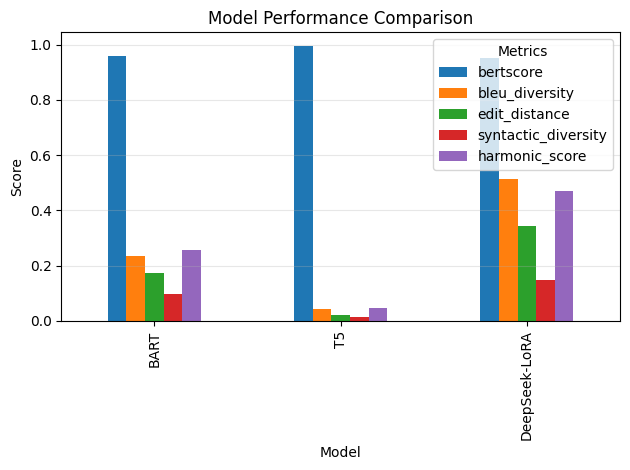

In [ ]:
with open("data/evaluation/results_bart.json", "r") as f:
    bart_results = json.load(f)

with open("data/evaluation/results_t5.json", "r") as f:
    t5_results = json.load(f)
    
with open("data/evaluation/results_deepseek.json", "r") as f:
    deepseek_results = json.load(f)

models = ["BART", "T5", "DeepSeek-LoRA"]
metrics = ["bertscore", "bleu_diversity", "edit_distance", "syntactic_diversity", "harmonic_score"]

# Extract overall metrics
comparison_data = {}
comparison_data["BART"] = bart_results["aggregate"]["avg_metrics"]
comparison_data["T5"] = t5_results["aggregate"]["avg_metrics"]
comparison_data["DeepSeek-LoRA"] = deepseek_results["aggregate"]["avg_metrics"]

comparison_df = pd.DataFrame(comparison_data).T
display(comparison_df[metrics])

plt.figure(figsize=(12, 6))
comparison_df[metrics].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metrics')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:

def find_example(domain):
    """Find an example ID that exists in all three result sets"""
    bart_ids = set(item["id"] for item in bart_results["detailed"] if item["category"] == domain)
    t5_ids = set(item["id"] for item in t5_results["detailed"] if item["category"] == domain)
    deepseek_ids = set(item["id"] for item in deepseek_results["detailed"] if item["category"] == domain)
    
    common_ids = bart_ids.intersection(t5_ids).intersection(deepseek_ids)
    return list(common_ids)[0] if common_ids else None

def show_example(domain):
    """Show paraphrase examples from all models for a given domain"""
    example_id = find_example(domain)
    if not example_id:
        print(f"No common example found for {domain} domain")
        return
    
    bart_item = next(item for item in bart_results["detailed"] if item["id"] == example_id)
    t5_item = next(item for item in t5_results["detailed"] if item["id"] == example_id)
    deepseek_item = next(item for item in deepseek_results["detailed"] if item["id"] == example_id)
    
    print(f"Domain: {domain.upper()}")
    print(f"Original: {bart_item['original']}")
    print("\nParaphrases:")
    print(f"BART: {bart_item['generated_paraphrase']}")
    print(f"T5: {t5_item['generated_paraphrase']}")
    print(f"DeepSeek-LoRA: {deepseek_item['generated_paraphrase']}")
    
    # Show metrics for this example
    example_metrics = pd.DataFrame({
        'BART': bart_item['scores'],
        'T5': t5_item['scores'],
        'DeepSeek-LoRA': deepseek_item['scores']
    }).T[metrics]
    
    print("\nMetrics for this example:")
    display(example_metrics)
    print("-" * 80)

# Show examples from each domain
for domain in ["literary", "technical", "academic", "article"]:
    show_example(domain)

Domain: LITERARY
Original: Day after day passed away without bringing any other tidings of him than the report which shortly prevailed in Meryton of his coming no more to Netherfield the whole winter; a report which highly incensed Mrs. Bennet, and which she never failed to contradict as a most scandalous falsehood.

Paraphrases:
BART: Paraphrase: Day after day passed away without bringing any other news of him than the report which shortly prevailed in Meryton of his coming no more to Netherfield for the whole winter, a report which highly incensed Mrs. Bennet and which she never failed to contradict.
T5: Day after day passed away without bringing any other tidings of him than the report which shortly prevailed in Meryton of his coming no more to Netherfield the whole winter; a report which highly incensed Mrs. Bennet, and which she never failed to contradict as a scandalous falsehood.
DeepSeek-LoRA: Day after day passed without any news of him other than the report in Meryton that he

,bertscore,bleu_diversity,edit_distance,syntactic_diversity,harmonic_score
BART,0.961170,0.248545,0.189655,0.150000,0.330106
T5,0.997983,0.039650,0.017241,0.000000,0.038877
DeepSeek-LoRA,0.958008,0.630102,0.358621,0.157895,0.558361


--------------------------------------------------------------------------------
Domain: TECHNICAL
Original: Learn Once, Write Anywhere: We don't make assumptions about the rest of your technology stack, so you can develop new features in React without rewriting existing code.

Paraphrases:
BART: Paraphrase: Learn once, write anywhere: We don't make assumptions about the rest of your technology stack, so you can develop new features in React without rewriting existing code.
T5: Learn Once, Write Anywhere: We don't make assumptions about the rest of your technology stack, so you can develop new features in React without rewriting existing code.
DeepSeek-LoRA: We don't make assumptions about the rest of your technology stack, so you can develop new features in React without rewriting existing code.

Metrics for this example:


,bertscore,bleu_diversity,edit_distance,syntactic_diversity,harmonic_score
BART,0.967452,0.060665,0.066667,0.058824,0.112539
T5,1.000000,0.000000,0.000000,0.000000,0.000000
DeepSeek-LoRA,0.959586,0.206077,0.166667,0.117647,0.277000


--------------------------------------------------------------------------------
Domain: ACADEMIC
Original: Subsequently, we introduce our infrastructures, encompassing our compute clusters, the training framework, the support for FP8 training, the inference deployment strategy, and our suggestions on future hardware design.

Paraphrases:
BART: Paraphrase: Subsequently, we introduce our infrastructures, which include our compute clusters, the training framework, the support for FP8 training, the inference deployment strategy and our suggestions on future hardware design.
T5: Subsequently, we introduce our infrastructures, encompassing our compute clusters, the training framework, the support for FP8 training, the inference deployment strategy, and our suggestions on future hardware design.
DeepSeek-LoRA: Following that, we present our infrastructure, which includes our compute clusters, the training framework, support for FP8 training, the inference deployment strategy, and our recomme

,bertscore,bleu_diversity,edit_distance,syntactic_diversity,harmonic_score
BART,0.968842,0.170717,0.108696,0.125,0.256562
T5,1.000000,0.000000,0.000000,0.000,0.000000
DeepSeek-LoRA,0.963042,0.330498,0.219178,0.200,0.415937


--------------------------------------------------------------------------------
Domain: ARTICLE
Original: Once they’re reliable enough, they’ll become the only responsible choice for almost all important tasks, ranging from legal rulings and financial planning to healthcare decisions.

Paraphrases:
BART: Paraphrase: Once they're reliable enough, they'll become the only responsible choice for almost all important tasks, ranging from legal rulings and financial planning to healthcare decisions.
T5: Once they’re reliable enough, they’ll become the only responsible choice for almost all important tasks, ranging from legal rulings and financial planning to healthcare decisions.
DeepSeek-LoRA: When they prove to be trustworthy enough, they’ll serve as the only responsible option for nearly all significant tasks, from legal decisions to financial planning and healthcare choices.

Metrics for this example:


,bertscore,bleu_diversity,edit_distance,syntactic_diversity,harmonic_score
BART,0.967384,0.195177,0.073298,0.000000,0.177292
T5,1.000000,0.000000,0.000000,0.000000,0.000000
DeepSeek-LoRA,0.967668,0.705679,0.406417,0.166667,0.601308


--------------------------------------------------------------------------------


# 6. Conclusion

Based on our evaluation, DeepSeek-LoRA demonstrates superior performance in paraphrase generation across multiple metrics and domains compared to the baseline models (BART and T5):

1. Semantic Preservation: All three models maintain high semantic similarity (BERTScore > 0.95), with T5 achieving nearly perfect scores but at the cost of minimal rephrasing
2. Lexical and Structural Diversity: DeepSeek-LoRA significantly outperforms both baseline models in diversity metrics:

- 2.2× higher BLEU diversity than BART (0.51 vs 0.23)
- 12× higher BLEU diversity than T5 (0.51 vs 0.04)
- 2× higher edit distance than BART (0.34 vs 0.17)
- 1.5× higher syntactic diversity than BART (0.15 vs 0.09)

3. Overall Balance: DeepSeek-LoRA achieves the best harmonic score (0.47), maintaining a strong balance between meaning preservation and creative rephrasing.

# 7. Future work

Our paraphrasing project offers several promising directions for future research:

### Dataset Improvements
Create a larger, more diverse training dataset that includes more specialized technical and academic content

### Architecture Exploration
- Test State Space Models like Mamba SSM for paraphrase generation
- Experiment with different Parameter-Efficient Fine-Tuning techniques
- Compare performance across model sizes and architectures

### Evaluation Enhancements
- Use big name LLMs (Claude, GPT-4o) to score paraphrases on a 1-5 scale (on multiple metric specified like diversity, truthfullness to meaning ...)
- Add human evaluation to validate automatic metrics (If can hire people)

### New Training alignement
- Implement RLHF to better align with human judgments (or DPO on paraphrase pairs)
- Explore contrastive learning approaches (teacher could be gpt4o or something / student the deepseek model we have)